In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np
import torch
import random
import glob
import matplotlib.pyplot as plt

# Data Parser

In [2]:
class ResidueEnvironmentDensity():
    """
    Environment class, which contains all the relevant information on the structural environment
    """
    def __init__(self, coords_2d_arr, atom_types, aa_onehot):
        self.coords_2d_arr = coords_2d_arr
        self.atom_types = atom_types
        self.aa_onehot = aa_onehot
    def get_coords_2d_arr(self):
        return self.coords_2d_arr
    def get_aa_onehot(self):
        return self.aa_onehot
    def get_atom_types(self):
        return self.atom_types

def parse_data(coordinate_features_filenames):
    """
    Function that parses environment files ("coordinate_features.npz") and 
    returns ResidueEnvironmentDensity objects
    """
    env_objects = []
    for i in range(len(coordinate_features_filenames)):
        coordinate_features = np.load(coordinate_features_filenames[i])

        atom_coords_prot_seq = coordinate_features["positions"]
        restype_onehots_prot_seq = coordinate_features["aa_onehot"]
        selector_prot_seq = coordinate_features["selector"]
        atom_types_flattened = coordinate_features["atom_types_numeric"]
        # Loop over protein sequence
        N_residues = selector_prot_seq.shape[0]
        for resi_i in range(N_residues):
            # Loop over surrounding atoms in the environment from the perspective of the residues
            selector = selector_prot_seq[resi_i]
            selector_masked = selector[ selector > -1 ] # Remove Filler
            coords_mask = atom_coords_prot_seq[resi_i, :, 0] != -99.0 # To remove filler

            # Relevant data
            coords = atom_coords_prot_seq[resi_i][ coords_mask ]            
            atom_types = atom_types_flattened[selector_masked]
            restype_onehot = restype_onehots_prot_seq[resi_i]
            env_objects.append(ResidueEnvironmentDensity(coords, atom_types, restype_onehot))            
    return env_objects

def get_batch_x_and_batch_y(res_env_obj_list):
    """
    Function that takes a list of ResidueEnvironmentDensity objects and returns
    batches with dimensions that match the requirements of the CNN for x and y
    """
    batch_aa_onehots = []
    batch_coords = []
    batch_atom_types = []
    for i, res_env_obj in enumerate(res_env_obj_list):
        batch_aa_onehots.append(res_env_obj.get_aa_onehot())
        batch_coords.append(res_env_obj.get_coords_2d_arr())
        batch_atom_types.append(res_env_obj.get_atom_types())
    
    env_data_all = []
    for env_i in range(len(batch_coords)):
        n_atoms = np.array(batch_coords[env_i]).shape[0]
        env_i_vector = np.zeros(n_atoms)+i 
        atom_types = batch_atom_types[env_i]
        coords = batch_coords[env_i]
        env_data = np.hstack( [np.reshape(np.zeros(n_atoms)+env_i, [-1, 1]), np.reshape(atom_types, [-1, 1]), coords] )
        env_data_all.append(env_data)
        
    env_data_all_stacked = np.vstack(env_data_all)
    return env_data_all_stacked, np.array(batch_aa_onehots)

# Model

In [3]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class AAPredConv3d(torch.nn.Module):
    def __init__(self, device, sigma = 0.6):
        super().__init__()
        self.device = device
        self.n_atom_types = 6
        self.p = 1.0 # Bins pr. Anstrom
        self.n = 18  # Grid dimension
        self.sigma = sigma # width of gaussian
        self.sigma_p = self.sigma*self.p
        self.a = np.linspace(start = -self.n / 2 * self.p + self.p / 2, 
                             stop  = self.n / 2 * self.p - self.p / 2, 
                             num=self.n) # The torch equivalent does not work for this.
        self.xx, self.yy, self.zz = torch.tensor(np.meshgrid(self.a, self.a, self.a, indexing="ij"),
                                                 dtype = torch.float32).to(self.device)
        # Model 
        self.conv1 = torch.nn.Sequential(
                                         torch.nn.Conv3d(6, 16, kernel_size=(3,3,3), stride=2, padding=1),
                                         torch.nn.ReLU(), 
                                         torch.nn.BatchNorm3d(16)
                                        )
        
        self.conv2 = torch.nn.Sequential(
                                         torch.nn.Conv3d(16, 32, kernel_size=(3,3,3), stride=2, padding=0),
                                         torch.nn.ReLU(), 
                                         torch.nn.BatchNorm3d(32)
                                        )
        self.conv3 = torch.nn.Sequential(
                                         torch.nn.Conv3d(32, 64, kernel_size=(3,3,3), stride=1, padding=1),
                                         torch.nn.ReLU(), 
                                         torch.nn.BatchNorm3d(64),
                                         Flatten()
                                        )
                                         
        self.dense1 = torch.nn.Sequential(
                                          torch.nn.Linear(in_features=4096, out_features=128),
                                          torch.nn.ReLU(), 
                                          torch.nn.BatchNorm1d(128)
                                         )
        self.dense2 = torch.nn.Linear(in_features=128, out_features=21, bias = True)
        
    def forward(self, x):
        current_batch_size = torch.unique(x[:, 0]).shape[0] # Used to build empty tensor fields_torch      
        fields_torch = torch.zeros((current_batch_size, self.n_atom_types, self.n, self.n, self.n)).to(device)
        
        # This for-loop takes the atomic coordinates and places them in a grid
        # with "gaussian blurring". The gaussian blurring gives a super-resolution effect
        # compared to the standard binning of atom in a grid.
        for j in range(self.n_atom_types):
            mask_j = x[:,1]==j
            atom_type_j_data = x[mask_j]
            if atom_type_j_data.shape[0] > 0:
                pos = atom_type_j_data[:, 2:]
                density = torch.exp(-((torch.reshape(self.xx, [-1, 1]) - pos[:,0])**2 +\
                                      (torch.reshape(self.yy, [-1, 1]) - pos[:,1])**2 +\
                                      (torch.reshape(self.zz, [-1, 1]) - pos[:,2])**2) / (2 * self.sigma_p**2))
                # Normalize each atom to 1
                density /= torch.sum(density, dim=0)
                # Since column 0 of atom_type_j_data is sorted
                # I can use a trick to detect the boundaries based
                # on the change from one value to another.
                change_mask_j = (atom_type_j_data[:,0][:-1] != atom_type_j_data[:,0][1:]) # detect change in column 0
                # Add begin- and end indices
                ranges_i = torch.cat([torch.tensor([0]),
                                      torch.arange(atom_type_j_data.shape[0]-1)[change_mask_j]+1, 
                                      torch.tensor([atom_type_j_data.shape[0]]) ])
                for i in range(ranges_i.shape[0]):
                    if i < ranges_i.shape[0] - 1:
                        index_0, index_1 = ranges_i[i], ranges_i[i+1]
                        fields = torch.reshape(torch.sum(density[:,index_0:index_1], dim = 1), 
                                               [self.n, self.n, self.n])
                        fields_torch[i,j,:,:,:] = fields

        # Convolutional layers
        x = self.conv1(fields_torch)
        x = self.conv2(x)
        x = self.conv3(x)
        # Dense layers
        x = self.dense1(x)
        x = self.dense2(x)
        return x 

## Parse

In [4]:
# Parse environment files (one per protein)
env_filenames_wild_card = "data/transfer_learning_data/structural_environments/*coord*"
env_filenames = sorted(glob.glob(env_filenames_wild_card))
random.shuffle(env_filenames) # sort for good measure
env_filenames_train = env_filenames[:220] # proteins for training
env_filenames_test = env_filenames[220:] #  proteins for testing

env_objects_train = parse_data(env_filenames_train)
env_objects_test = parse_data(env_filenames_test)
print ("Number of training environments:", len(env_objects_train))
print ("Number of testing environments: ", len(env_objects_test))


Number of training environments: 97711
Number of testing environments:  13289


## Train

In [5]:
# Settings
device = "cuda"
sigma = 0.6 # corresponds to the stdev of the "gaussian blurring" of the atoms
batch_size = 100 # Number of environments
learning_rate = 0.0003
epochs = 1

# Define model
aa_pred_conv3d = AAPredConv3d(device, sigma = sigma).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(aa_pred_conv3d.parameters(), lr = learning_rate)
random.shuffle(env_objects_train)

# Define random subsets of training and testing sets for evaluation.
# This makes it simpler to fit in a single forward pass (memory-wise), 
# instead of iterating over all the data
sample_size = 500
train_eval_inds = np.random.choice(np.arange(len(env_objects_train)), size = sample_size, replace = False)
test_eval_inds = np.random.choice(np.arange(len(env_objects_test)), size = sample_size, replace = False)
env_objects_train_eval = [env_objects_train[ind] for ind in train_eval_inds]
env_objects_test_eval = [env_objects_test[ind] for ind in test_eval_inds]
x_train_torch, y_train_torch = [torch.tensor(tens, dtype = torch.float32, requires_grad = False).to(device) for tens in get_batch_x_and_batch_y(env_objects_train_eval)]
x_test_torch, y_test_torch = [torch.tensor(tens, dtype = torch.float32, requires_grad = False).to(device) for tens in get_batch_x_and_batch_y(env_objects_test_eval)]

# Train
random.shuffle(env_objects_train)
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []
for epoch_i in range(epochs):
    for i in range(0, len(env_objects_train), batch_size):
        if i+batch_size > len(env_objects_train): # skip last batch if it is smaller than batch size (small batch might mess up batch norm)
            continue
        # Define training batch
        env_objs_batch_train = env_objects_train[i:i+batch_size]
        batch_x_train, batch_y_train = [torch.tensor(tens, dtype = torch.float32).to(device) for tens in get_batch_x_and_batch_y(env_objs_batch_train)]

        # Set the parameter gradients to zero
        # Forward pass, backward pass, optimize
        aa_pred_conv3d.train()
        optimizer.zero_grad()    
        batch_y_pred = aa_pred_conv3d(batch_x_train)
        labels = torch.argmax(batch_y_train, dim = -1)
        loss_batch_train = loss(batch_y_pred, labels)
        loss_batch_train.backward()
        optimizer.step()
        
        # Evaluate on the big subset of training and testing environments
        if i % 1000 == 0:
            aa_pred_conv3d.eval()
            
            # Training eval
            y_pred_train = aa_pred_conv3d(x_train_torch)
            labels_train_pred = torch.argmax(y_pred_train, dim = -1)
            labels_train = torch.argmax(y_train_torch, dim = -1)
            loss_train = loss(y_pred_train, labels_train).item()
            loss_train_list.append(loss_train)
            accuracy_train = torch.mean((labels_train == labels_train_pred).double()).item()
            acc_train_list.append(accuracy_train)
            
            # Testing eval
            y_pred_test = aa_pred_conv3d(x_test_torch)
            labels_test_pred = torch.argmax(y_pred_test, dim = -1)
            labels_test = torch.argmax(y_test_torch, dim = -1)
            loss_test = loss(y_pred_test, labels_test).item()
            loss_test_list.append(loss_test)
            accuracy_test = torch.mean((labels_test == labels_test_pred).double()).item()
            acc_test_list.append(accuracy_test)
            
            print ("epoch {:1d}/{:1d}, step {:6d}, loss(train): {:5.2f}, loss(test): {:5.2f}, accuracy(train): {:5.2f}, accuracy(test): {:5.2f}".format(epoch_i+1, epochs, i, loss_train, loss_test, accuracy_train, accuracy_test))
            
    # shuffle after each epoch
    random.shuffle(env_objects_train)

epoch 1/1, step      0, loss(train):  3.04, loss(test):  3.05, accuracy(train):  0.08, accuracy(test):  0.05
epoch 1/1, step   1000, loss(train):  3.04, loss(test):  3.07, accuracy(train):  0.08, accuracy(test):  0.05
epoch 1/1, step   2000, loss(train):  3.05, loss(test):  3.11, accuracy(train):  0.08, accuracy(test):  0.05
epoch 1/1, step   3000, loss(train):  3.04, loss(test):  3.12, accuracy(train):  0.09, accuracy(test):  0.07
epoch 1/1, step   4000, loss(train):  3.03, loss(test):  3.11, accuracy(train):  0.09, accuracy(test):  0.06
epoch 1/1, step   5000, loss(train):  2.97, loss(test):  3.04, accuracy(train):  0.10, accuracy(test):  0.08
epoch 1/1, step   6000, loss(train):  2.83, loss(test):  2.88, accuracy(train):  0.14, accuracy(test):  0.13
epoch 1/1, step   7000, loss(train):  2.60, loss(test):  2.63, accuracy(train):  0.26, accuracy(test):  0.23
epoch 1/1, step   8000, loss(train):  2.38, loss(test):  2.41, accuracy(train):  0.30, accuracy(test):  0.28
epoch 1/1, step   9

epoch 1/1, step  76000, loss(train):  1.63, loss(test):  1.78, accuracy(train):  0.51, accuracy(test):  0.43
epoch 1/1, step  77000, loss(train):  1.60, loss(test):  1.77, accuracy(train):  0.50, accuracy(test):  0.44
epoch 1/1, step  78000, loss(train):  1.59, loss(test):  1.81, accuracy(train):  0.50, accuracy(test):  0.43
epoch 1/1, step  79000, loss(train):  1.59, loss(test):  1.80, accuracy(train):  0.53, accuracy(test):  0.43
epoch 1/1, step  80000, loss(train):  1.58, loss(test):  1.78, accuracy(train):  0.52, accuracy(test):  0.44
epoch 1/1, step  81000, loss(train):  1.58, loss(test):  1.76, accuracy(train):  0.51, accuracy(test):  0.43
epoch 1/1, step  82000, loss(train):  1.57, loss(test):  1.76, accuracy(train):  0.52, accuracy(test):  0.43
epoch 1/1, step  83000, loss(train):  1.58, loss(test):  1.75, accuracy(train):  0.51, accuracy(test):  0.44
epoch 1/1, step  84000, loss(train):  1.56, loss(test):  1.73, accuracy(train):  0.50, accuracy(test):  0.45
epoch 1/1, step  85

## Plot

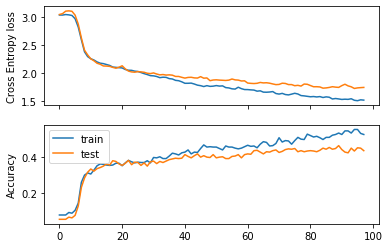

In [6]:
fig, ax_arr = plt.subplots(2, sharex = True)
ax_arr[0].plot(np.arange(len(loss_train_list)), loss_train_list, label = "train")
ax_arr[0].plot(np.arange(len(loss_test_list)), loss_test_list, label = "test")
ax_arr[1].plot(np.arange(len(acc_train_list)), acc_train_list, label = "train")
ax_arr[1].plot(np.arange(len(acc_test_list)), acc_test_list, label = "test")
ax_arr[0].set_ylabel("Cross Entropy loss")
ax_arr[1].set_ylabel("Accuracy")
plt.legend()
plt.show()

### Discussion
This demo demonstrates how to classify the missing amino acid from a structural environment where the atoms if the query amino acid have been purposefully removed.

I train a simple Conv3D net to learn the shape/contact-pattern that the missing atoms have left behind.

Given the very limited number of PDB structures (250) used in this demo, it is not surprising that we see much better performance on the training data compared to the testing data. Should you want to use the demo, please include more PDB structures. 
For reference, I use around 2k structures that have been homology reduces in sequence with much success.